<a href="https://colab.research.google.com/github/valebl/SSZ_Clustering/blob/main/DBSCAN_SSZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBSCAN

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN

%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('/content/drive/MyDrive/SeismicSources')

from utils import plot_italy, haversine_np, distance_np

Load the catalogue

In [7]:
filepath = "/content/drive/MyDrive/SeismicSources/CATALOGUE_FOCAL.xlsx"
df = pd.read_excel(filepath,usecols="A:N",engine="openpyxl")
df.set_index('Index',inplace=True)
df = df[['X','Y','MwDef','Year','LonDef','LatDef','EqID','rake_360']]
df = df.dropna(axis=0,how='any')
print(df.head(10))


                  X             Y  MwDef  ...  LatDef           EqID  rake_360
Index                                     ...                                 
0      7.331372e+05  4.816379e+06   4.86  ...  43.464  100500000000A     288.0
1      9.033421e+05  4.604211e+06   5.10  ...  41.488  100500000000B     203.0
2      9.850866e+05  4.569418e+06   4.63  ...  41.131  101904010000A     250.0
3      9.850866e+05  4.569418e+06   4.63  ...  41.131  104404190900A     250.0
5      5.952487e+05  5.043553e+06   5.10  ...  45.539  106503271125A      92.0
7      1.160782e+06  4.583025e+06   4.86  ...  41.129  108709100000A     149.0
8      7.884312e+05  4.644411e+06   5.10  ...  41.899  109101270000A     340.0
9      9.850866e+05  4.569418e+06   4.63  ...  41.131  109401140000A     250.0
10     6.580732e+05  5.014586e+06   6.52  ...  45.267  111701031515A     190.0
12     9.112262e+05  4.592288e+06   5.80  ...  41.377  112003250000A     203.0

[10 rows x 8 columns]


## Compute Lon-Lat distance matrix

In [33]:
LONG_ALL = df['LonDef'].values
LAT_ALL = df['LatDef'].values

DISTANCES_geo = np.array([haversine_np(lon, lat, LONG_ALL, LAT_ALL) for lon, lat in zip(LONG_ALL,LAT_ALL)])

max_dist = max(list(map(max, *DISTANCES_geo)))

DISTANCES_geo_norm = DISTANCES_geo / max_dist

In [41]:
len(DISTANCES_geo[0])

4703

## Compute distance matrix using UTM32N coordinates

In [21]:
X_ALL = df['X'].values
Y_ALL = df['Y'].values

X_ALL = (X_ALL - np.mean(X_ALL)) / np.std(X_ALL)
Y_ALL = (Y_ALL - np.mean(Y_ALL)) / np.std(Y_ALL)

DISTANCES_utm = np.array([distance_np(x, y, X_ALL, Y_ALL) for x, y in zip(X_ALL,Y_ALL)])

max_dist_utm = max(list(map(max, *DISTANCES_utm)))

DISTANCES_utm_norm = DISTANCES_utm # / max_dist_utm

## Compute Rake distance matirx

In [9]:
def rake_distance(r1, RAKE_ALL):
    return [min(abs(r1 - r2), 360 - abs(r1 - r2)) for r2 in RAKE_ALL]

In [31]:
RAKE_ALL = df['rake_360'].values

RAKE_ALL = (RAKE_ALL - np.mean(RAKE_ALL)) / np.std(RAKE_ALL)

DISTANCES_rake = np.array([rake_distance(r, RAKE_ALL) for r in RAKE_ALL])

max_dist_rake = max(list(map(max, *DISTANCES_rake)))

DISTANCES_rake_norm = DISTANCES_rake # / max_dist_rake

In [76]:
alpha = 0.9
beta = 1 - alpha

DISTANCES = alpha * DISTANCES_utm_norm + beta * DISTANCES_rake_norm

Estimated number of clusters: 27
Estimated number of noise points: 1703


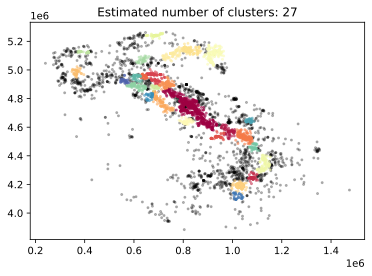

In [79]:
# ----------
# DBMSCAN
# ----------

eps = 0.1 # 0.1
min_samples = 30 # 30

db = DBSCAN(eps, min_samples, 'precomputed').fit(DISTANCES)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

k = -1
col = [0, 0, 0, 1]
class_member_mask = (labels == k)

xy = df[class_member_mask & core_samples_mask]
plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.25)

xy = df[class_member_mask & ~core_samples_mask]
plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.25)

for k, col in zip(unique_labels, colors):
    if k == -1:
        break

    class_member_mask = (labels == k)

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.5)

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.show()

cluster 0 - number of points: 795
cluster 1 - number of points: 75
cluster 2 - number of points: 72
cluster 3 - number of points: 131
cluster 4 - number of points: 71
cluster 5 - number of points: 47
cluster 6 - number of points: 134
cluster 7 - number of points: 99
cluster 8 - number of points: 140
cluster 9 - number of points: 41
cluster 10 - number of points: 409
cluster 11 - number of points: 155
cluster 12 - number of points: 70
cluster 13 - number of points: 60
cluster 14 - number of points: 192
cluster 15 - number of points: 93
cluster 16 - number of points: 45
cluster 17 - number of points: 32
cluster 18 - number of points: 30
cluster 19 - number of points: 39
cluster 20 - number of points: 75
cluster 21 - number of points: 35
cluster 22 - number of points: 37
cluster 23 - number of points: 33
cluster 24 - number of points: 30
cluster 25 - number of points: 30
cluster 26 - number of points: 30


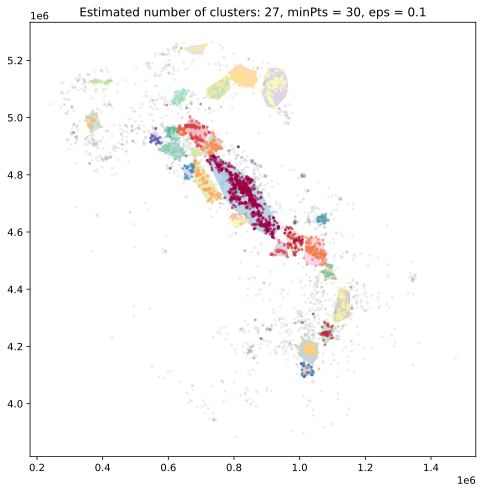

In [80]:
from scipy.spatial import ConvexHull
import matplotlib.cm as cm

clusts = labels
cmap = cm.get_cmap("hsv", len(np.unique(clusts)))


fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
# plt.scatter(df[['LonDef']], df[['LatDef']], c=clusts, cmap=plt.cm.viridis, alpha=1, s=10)
k = -1
col = [0, 0, 0, 1]
class_member_mask = (labels == k)

xy = df[class_member_mask & core_samples_mask]
plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.05)

xy = df[class_member_mask & ~core_samples_mask]
plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.05)
for k, col in zip(unique_labels, colors):
    if k == -1:
        break

    class_member_mask = (labels == k)

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.5)

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.5)
# plot centers
# plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# draw enclosure
for i in unique_labels:
    if i != -1:
      points = df[clusts == i][['X','Y']].values
      print(f'cluster {i} - number of points: {len(points)}')
      # get convex hull
      if len(points) > 2:
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                          points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                          points[hull.vertices,1][0])
        # plot shape
        plt.fill(x_hull, y_hull, alpha=0.3)
plt.title(f'Estimated number of clusters: {n_clusters_}, minPts = {min_samples}, eps = {eps}')
plt.show()
    
# plt.xlim(0,200)
# plt.ylim(0,200)